# Trabajo practico 2
# Deteccion y filtrado de señales ecg

# Chocobar Rene -- Caseres Martin

Se obtubieron dos señales reales de ecg de la pagina physionet.com.
Cada señal representa 10seg de grabacion con una frecuencia de muestreo de Fs=250hz, gain=800 desplazamiento de linea de base=0
y numero de muestras N=2500.
Una de las señales pertenece a un corazon sano, mientras que la otra presenta una severa fibrilacion ventricular.
Dichas señales son afectadas por ruidos de baja frecuencia, como ser movimientos involuntarios de los musculos, y el ruido de linea de alimentacion 50hz.
Luego, se utilizara una tecnica de filtrado que se conoce como recorte  de frecuencias por medio de la fft y la ifft. De esta forma se lograra una señal optima para ser estudiada.

('Pulsaciones por minutos', 64.748201438848923)


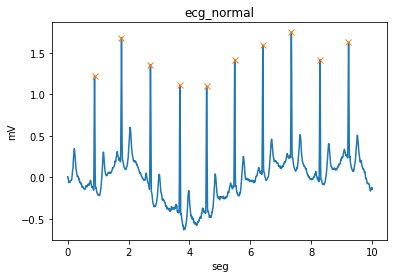

('pulsaciones por minutos', 220.91310751104564)


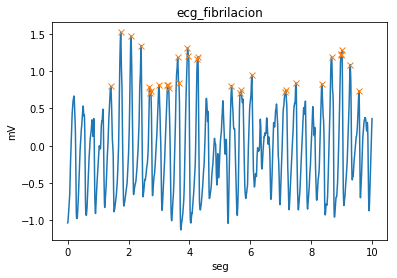

('pulsaciones por minutos', 1053.5331905781584)


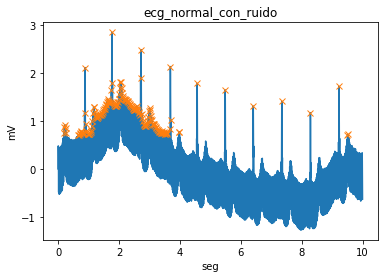

('pulsaciones por minutos', 1098.7654320987654)


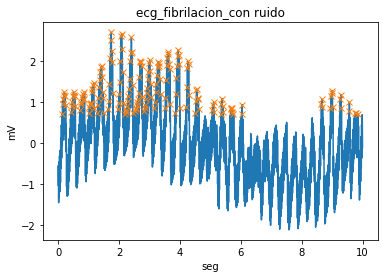

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from __future__ import division
from scipy.signal import find_peaks
import scipy.signal as sig
from scipy.fftpack import fft, ifft, fftshift, rfft, irfft
from IPython.html.widgets import *

x=loadmat("34m.mat")         #carga de dos señales ecg
y=loadmat("fibrilacion.mat")
yecg=(y["val"]-0)/800
ecg=(x["val"]-0)/800                  #dentro de la estructura del archivo .mat solo toma los valores del vector de la señal ecg 

ecg=np.transpose(ecg)                 #hace una transpuesta para tomar los datos para plotear correctamente
yecg=np.transpose(yecg)    



Fs= 250            #frecuencia de muestreo de las señales ecg originales
N= 2500            #numero de muestras de las señales ecg originales.


fl = 50                                    # Frecuencia de señal ruido linea
tr = np.arange(0, N/Fs, 1/Fs)
xr = 0.5*np.sin(2*np.pi*fl*tr)             #ruido de linea
fm=0.1
xr2 = 0.8*np.sin(2*np.pi*fm*tr)            #ruido muscular baja fruencia

ecgruido=np.zeros(len(ecg))                #se suma el ruido al la señal ecg y se trasforma en ecgruido
for i in range (len(ecg)):
    ecgruido[i]=ecg[i]+xr[i]+xr2[i]
    i=i+1

rn=ecgruido                               #copia del ecg normal con ruido para sacar fft    

yecgruido=np.zeros(len(yecg))             #se le suma el ruido a la señal yecg y se transforma en yecgruido 
for i in range(len(yecg)):
    yecgruido[i]=yecg[i]+xr[i]+xr2[i]
    i=i+1
    
rf=yecgruido                              #hace una copia del yecg con ruido para hacer la fft

ecgruido=np.transpose([ecgruido])
yecgruido=np.transpose([yecgruido])
   
ts=1/Fs
t=np.linspace(0,np.size(ecg),np.size(ecg))*ts #genero el vector tiempo, cada muestra tiene el tiempo de muestreo

def picos(ecg):# censado de la señal, obtengo sus paramtros característicos
    ecg=np.transpose(ecg) 
    R,_= find_peaks(ecg[0], height=0.7)#cargo el vector con los picos superiors a 0,7mV a fin de optener los picos R
    picos=np.zeros(len(R)-1)#A fin de sacar el frecuencia genero un vector para cargar las distancia entre picos
    for j in range (0,len(picos)):
        picos[j]=R[j+1]-R[j]
    frec=60/(np.mean(picos)*ts)#saco el promedio de los periodos y al multiplicar por ts y 60, tengo las pulsaciones por min.
    return (R, frec)



R,_=picos(ecg)
frec=picos(ecg)[1]
print("Pulsaciones por minutos", frec)
plt.plot(t,ecg)
plt.plot(R*ts, ecg[R], "x")# tomo los valores de los picos  los superpongo sobre la grafica
plt.title("ecg_normal")
plt.xlabel("seg")
plt.ylabel("mV")
plt.show()


R,_=picos(yecg)
frec=picos(yecg)[1]
print("pulsaciones por minutos", frec)
plt.plot(t,yecg)
plt.plot(R*ts, yecg[R], "x") # tomo los valores de los picos  los superpongo sobre la grafica
plt.title("ecg_fibrilacion")
plt.xlabel("seg")
plt.ylabel("mV")
plt.show()


R,_=picos(ecgruido)
frec=picos(ecgruido)[1]
print("pulsaciones por minutos", frec)
plt.title("ecg_normal_con_ruido")
plt.xlabel("seg")
plt.ylabel("mV")
plt.plot(t,ecgruido)
plt.plot(R*ts, ecgruido[R], "x") # tomo los valores de los picos  los superpongo sobre la gráfica con una "x"
plt.show()

R,_=picos(yecgruido)
frec=picos(yecgruido)[1]
print("pulsaciones por minutos", frec)
plt.title("ecg_fibrilacion_con ruido")
plt.xlabel("seg")
plt.ylabel("mV")
plt.plot(t,yecgruido)
plt.plot(R*ts, yecgruido[R], "x") # tomo los valores de los picos  los superpongo sobre la gráfica con una "x"


Ahora, intentamos tomar una lectura de los pulsos por minuto (ppm) de la señal normal y la señal con arritmia obtenidas de la pagina physionet.com. Vemos que nos da 64ppm y 220ppm respectivamente.podemos observar que la señal normal tiene un desnivel de linea de base al igual que la señal con arritmia. Esto hace que la lectura que tomemos sea propensa a grandes errores. Luego, si afectmos a las señales con ruido estos errores se incrementan notoriamente como lo dicen las nuevas lecturas de 1053ppm para el ecg normal y 1098 para el ecg con arritmia.  

# Ahora vemos los espectros de las señales, las filtramos y obtenemos los picos y las verdaderas ppm.

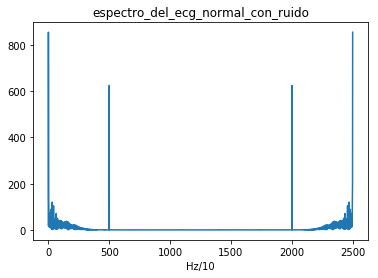

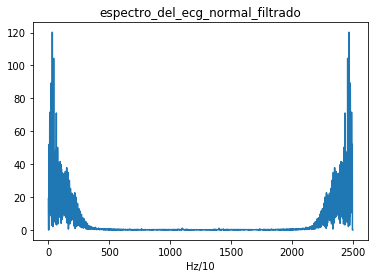

('pulsaciones por minutos ecg normal filtrado', 64.748201438848923)


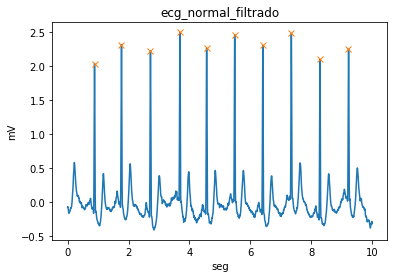

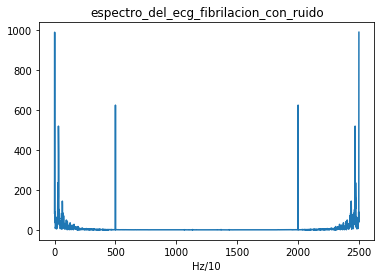

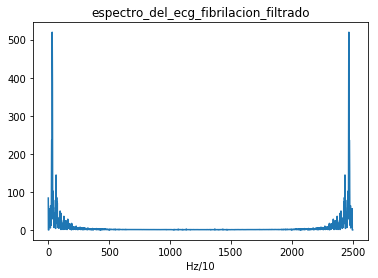

('pulsaciones por minutos ecg fibrilacion filtrado', 223.97610921501706)


Text(0,0.5,'mV')

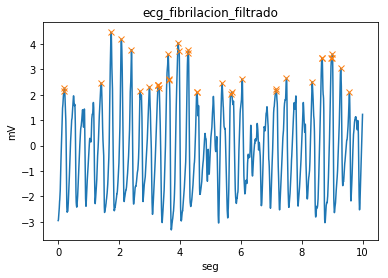

In [60]:


plt.plot(abs(fft(rn)))                         #ploteo del espectro ecg normal con ruido
plt.title("espectro_del_ecg_normal_con_ruido")
plt.xlabel("Hz/10")
plt.show()

def fft_filter(signal,*bin_to_delete):    #filtro que recorta una seccion del espectro
    spec = (fft(signal))
    for i in bin_to_delete:
        spec[i]=0
        spec[len(spec)-i]=0
    return ifft(spec)
    
a = np.arange(1,5,1)            #corresponde a la seccion del espectro de contiene el ruido muscular baja frecuencia 0,1 a      0,5hz 
b=np.arange(499,501,1)          #corresponde a la seccion del espectro que contiene el ruido de linea 50hz

sf = fft_filter(rn,a)     #filtrado         
sf2=fft_filter(sf,b)

def picosfiltro(ecg):# censado de la señal, obtengo sus paramtros característicos
    ecg=np.transpose(ecg) 
    R,_= find_peaks(ecg[0], height=2)#cargo el vector con los picos superiors a 0,7mV a fin de optener los picos R
    picos=np.zeros(len(R)-1)#A fin de sacar el frecuencia genero un vector para cargar las distancia entre picos
    for j in range (0,len(picos)):
        picos[j]=R[j+1]-R[j]
    frec=60/(np.mean(picos)*ts)#saco el promedio de los periodos y al multiplicar por ts y 60, tengo las pulsaciones por min.    
    return (R, frec)

plt.plot(abs(fft(sf2)))
plt.title("espectro_del_ecg_normal_filtrado")
plt.xlabel("Hz/10")
plt.show()

sf2=np.transpose([sf2])                        #para poder sacar los picos debemos elevar el nivel de la señal
sf2=1.6*sf2
plt.show()

R,_=picosfiltro(sf2)
frec=picosfiltro(sf2)[1]
print("pulsaciones por minutos ecg normal filtrado", frec)

plt.plot(t,sf2)
plt.plot(R*ts, sf2[R], "x")
plt.title("ecg_normal_filtrado")
plt.xlabel("seg")
plt.ylabel("mV")
plt.show()

plt.plot(abs(fft(rf)))
plt.title("espectro_del_ecg_fibrilacion_con_ruido")
plt.xlabel("Hz/10")
plt.show()

sf3 = fft_filter(rf,a)
sf4= fft_filter(sf3,b)

plt.plot(abs(fft(sf4)))
plt.title("espectro_del_ecg_fibrilacion_filtrado")
plt.xlabel("Hz/10")
plt.show()

sf4=np.transpose([sf4])                        #para poder sacar los picos debemos elevar el nivel de la señal
sf4=3*sf4
plt.show()

R,_=picosfiltro(sf4)
frec=picosfiltro(sf4)[1]
print("pulsaciones por minutos ecg fibrilacion filtrado", frec)
plt.plot(t,sf4)
plt.plot(R*ts, sf4[R], "x")
plt.title("ecg_fibrilacion_filtrado")
plt.xlabel("seg")
plt.ylabel("mV")














#Conclusion:

 Una vez filtrado los ruidos de las señales ecg normal y con arritmia se pudieron obtener las verdederas ppm. Estas son 64ppm y 223ppm respectivamente. Como se sabe, el BW de las señales ecg va desde 0 a 100hz. Con ello, podemos observar lo poderoso de la tecnica de filtrao por extraccion de espectro usando la fft. Esta herramienta nos permite extraer en forma quirurgica frecuencias indeseadas como ser ruido de linea, que esta dentro del BW de la señal ecg, sin que se pierda informacion. Ademas, al extraerle las frecuencias menores a 0,5hz, las señales se han estabilizado en linea de base. Por ello, la obtencion de los picos resulto mas sencilla y se pudo diagnosticar las señales como normal y con arritmia severa. Ahora, una vez obtenido los picos en forma precisa, se puede sincronizar un cordioversor para que dispare 5mseg despues de que pasen estos. 